# Multi-Horizon LSTM Model Training
Build and train LSTM models for Gulf hypoxia prediction

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(5550)
tf.random.set_seed(5550)

In [28]:
DATA_DIR = Path('data/modeling')
OUTPUT_DIR = Path('models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 8
EPOCHS = 200
PATIENCE = 30  # Early stopping patience

In [29]:
X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

n_samples_train, n_timesteps, n_features = X_train.shape
n_targets = y_train.shape[1]

print(f"  Training samples: {n_samples_train}")
print(f"  Timesteps (sequence length): {n_timesteps}")
print(f"  Features per timestep: {n_features}")
print(f"  Target zones: {n_targets}")

  X_train: (51, 6, 30)
  y_train: (51, 3)
  X_val: (9, 6, 30)
  y_val: (9, 3)
  X_test: (6, 6, 30)
  y_test: (6, 3)
  Training samples: 51
  Timesteps (sequence length): 6
  Features per timestep: 30
  Target zones: 3


In [30]:
def build_lstm_model_v1(input_shape, n_targets, name="lstm_v1"):
    """
    Basic LSTM model with 2 LSTM layers
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer (3 zones, no activation for regression)
    model.add(layers.Dense(n_targets))
    
    return model

def build_lstm_model_v2(input_shape, n_targets, name="lstm_v2"):
    """
    Deeper LSTM model with 3 LSTM layers
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # LSTM layers
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(16, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(n_targets))
    
    return model

def build_lstm_model_v3(input_shape, n_targets, name="lstm_v3"):
    """
    Bidirectional LSTM model
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # Bidirectional LSTM layers
    model.add(layers.Bidirectional(
        layers.LSTM(64, return_sequences=True)
    ))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Bidirectional(
        layers.LSTM(32, return_sequences=False)
    ))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer
    model.add(layers.Dense(n_targets))
    
    return model

# Build all model variants
input_shape = (n_timesteps, n_features)

models_to_train = {
    'lstm_v1': build_lstm_model_v1(input_shape, n_targets),
    'lstm_v2': build_lstm_model_v2(input_shape, n_targets),
    'lstm_v3_bidirectional': build_lstm_model_v3(input_shape, n_targets),
}

print("\nModel architectures:")
for name, model in models_to_train.items():
    print(f"\n{name.upper()}:")
    model.summary()
    print(f"  Total parameters: {model.count_params():,}")


Model architectures:

LSTM_V1:


Model: "lstm_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 6, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,315 (145.76 KB)

 Trainable params: 37,315 (145.76 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 37,315

LSTM_V2:


Model: "lstm_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_7 (Masking)             │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 6, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,867 (565.89 KB)

 Trainable params: 144,867 (565.89 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 144,867

LSTM_V3_BIDIRECTIONAL:


Model: "lstm_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_8 (Masking)             │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 6, 128)         │        48,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,947 (355.26 KB)

 Trainable params: 90,947 (355.26 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 90,947


In [32]:
training_histories = {}

for model_name, model in models_to_train.items():
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name.upper()}")
    print(f"{'='*80}")
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    training_histories[model_name] = history.history
    
    # Save model
    model.save(OUTPUT_DIR / f'{model_name}.keras')
    print(f"\n✓ Saved model: {model_name}.keras")

# Save training histories
with open(OUTPUT_DIR / 'training_histories.pkl', 'wb') as f:
    pickle.dump(training_histories, f)


TRAINING: LSTM_V1
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 348.6008 - mae: 11.0429 - val_loss: 81.8122 - val_mae: 5.6883 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 345.9314 - mae: 10.9923 - val_loss: 81.3727 - val_mae: 5.7164 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 344.0006 - mae: 10.9905 - val_loss: 80.3751 - val_mae: 5.7289 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 340.8495 - mae: 10.9455 - val_loss: 78.7294 - val_mae: 5.7391 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 335.4670 - mae: 10.9018 - val_loss: 76.3031 - val_mae: 5.7663 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 327.8455 - mae: 10.8309 - val_loss: 72.9639 - val_mae: 5.7845 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 317.9852 - mae: 10.6596 - val_loss: 69.7767 - val_mae: 5.80

In [33]:
zone_names = ['Zone 1 (Louisiana)', 'Zone 2 (Texas)', 'Zone 3 (Mexico)']

def evaluate_model(model, X, y, dataset_name):
    """Evaluate model and return metrics"""
    
    y_pred = model.predict(X, verbose=0)
    
    # Overall metrics
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Per-zone metrics
    zone_metrics = []
    for i, zone_name in enumerate(zone_names):
        zone_mse = mean_squared_error(y[:, i], y_pred[:, i])
        zone_mae = mean_absolute_error(y[:, i], y_pred[:, i])
        zone_r2 = r2_score(y[:, i], y_pred[:, i])
        
        zone_metrics.append({
            'zone': zone_name,
            'mse': zone_mse,
            'mae': zone_mae,
            'r2': zone_r2
        })
    
    return {
        'dataset': dataset_name,
        'overall_mse': mse,
        'overall_mae': mae,
        'overall_r2': r2,
        'zone_metrics': zone_metrics,
        'predictions': y_pred
    }

# Evaluate all models
results = {}

for model_name, model in models_to_train.items():
    print(f"\n{model_name.upper()}:")
    print(f"{'-'*40}")
    
    model_results = {
        'train': evaluate_model(model, X_train, y_train, 'train'),
        'val': evaluate_model(model, X_val, y_val, 'validation'),
        'test': evaluate_model(model, X_test, y_test, 'test')
    }
    
    results[model_name] = model_results
    
    # Print results
    for dataset in ['train', 'val', 'test']:
        res = model_results[dataset]
        print(f"\n  {dataset.upper()}:")
        print(f"    Overall MAE: {res['overall_mae']:.2f}%")
        print(f"    Overall R²: {res['overall_r2']:.3f}")
        print(f"    Per-zone MAE:")
        for zone_metric in res['zone_metrics']:
            print(f"      {zone_metric['zone']}: {zone_metric['mae']:.2f}%")

# Save results
with open(OUTPUT_DIR / 'evaluation_results.pkl', 'wb') as f:
    pickle.dump(results, f)


LSTM_V1:
----------------------------------------

  TRAIN:
    Overall MAE: 7.91%
    Overall R²: -0.299
    Per-zone MAE:
      Zone 1 (Louisiana): 5.59%
      Zone 2 (Texas): 17.30%
      Zone 3 (Mexico): 0.84%

  VAL:
    Overall MAE: 5.97%
    Overall R²: -0.415
    Per-zone MAE:
      Zone 1 (Louisiana): 7.63%
      Zone 2 (Texas): 7.68%
      Zone 3 (Mexico): 2.60%

  TEST:
    Overall MAE: 4.38%
    Overall R²: -1.823
    Per-zone MAE:
      Zone 1 (Louisiana): 3.41%
      Zone 2 (Texas): 9.24%
      Zone 3 (Mexico): 0.49%

LSTM_V2:
----------------------------------------

  TRAIN:
    Overall MAE: 8.29%
    Overall R²: -0.368
    Per-zone MAE:
      Zone 1 (Louisiana): 5.66%
      Zone 2 (Texas): 18.35%
      Zone 3 (Mexico): 0.84%

  VAL:
    Overall MAE: 5.77%
    Overall R²: -0.311
    Per-zone MAE:
      Zone 1 (Louisiana): 7.58%
      Zone 2 (Texas): 7.11%
      Zone 3 (Mexico): 2.61%

  TEST:
    Overall MAE: 3.86%
    Overall R²: -2.132
    Per-zone MAE:
      Zone 1 

In [34]:
comparison_df = []
for model_name, model_results in results.items():
    comparison_df.append({
        'model': model_name,
        'train_mae': model_results['train']['overall_mae'],
        'val_mae': model_results['val']['overall_mae'],
        'test_mae': model_results['test']['overall_mae'],
        'train_r2': model_results['train']['overall_r2'],
        'val_r2': model_results['val']['overall_r2'],
        'test_r2': model_results['test']['overall_r2']
    })

comparison_df = pd.DataFrame(comparison_df)
comparison_df = comparison_df.sort_values('val_mae')

print("\n📊 Model Comparison (sorted by validation MAE):")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['model']
print(f"\n🏆 Best model: {best_model_name}")
print(f"  Validation MAE: {comparison_df.iloc[0]['val_mae']:.2f}%")
print(f"  Test MAE: {comparison_df.iloc[0]['test_mae']:.2f}%")


📊 Model Comparison (sorted by validation MAE):
                model  train_mae  val_mae  test_mae  train_r2    val_r2   test_r2
              lstm_v2   8.285475 5.765490  3.862958 -0.367823 -0.311088 -2.132094
              lstm_v1   7.911507 5.969230  4.377858 -0.298683 -0.415335 -1.822782
lstm_v3_bidirectional   8.399872 6.223609  3.247062 -0.667671 -0.652855 -0.057205

🏆 Best model: lstm_v2
  Validation MAE: 5.77%
  Test MAE: 3.86%


Saved: training_histories.png
Saved: predictions_vs_actual_test.png


KeyError: 'test_horizons'

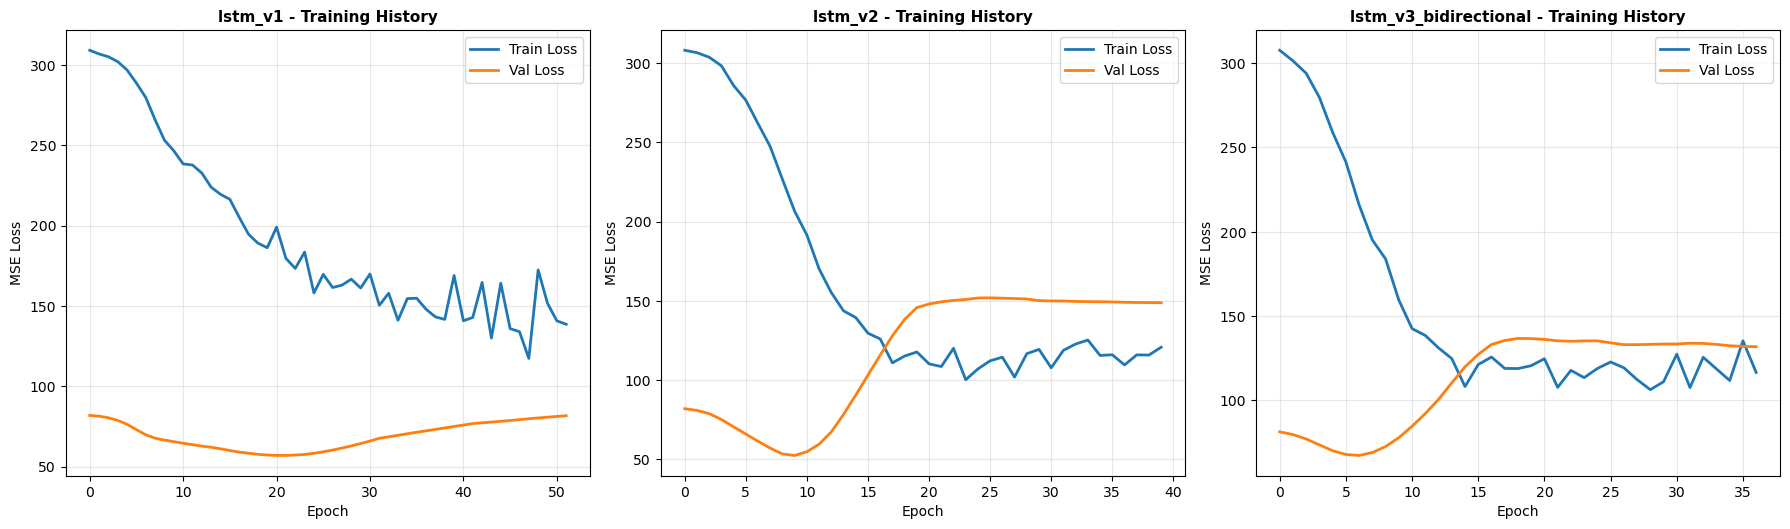

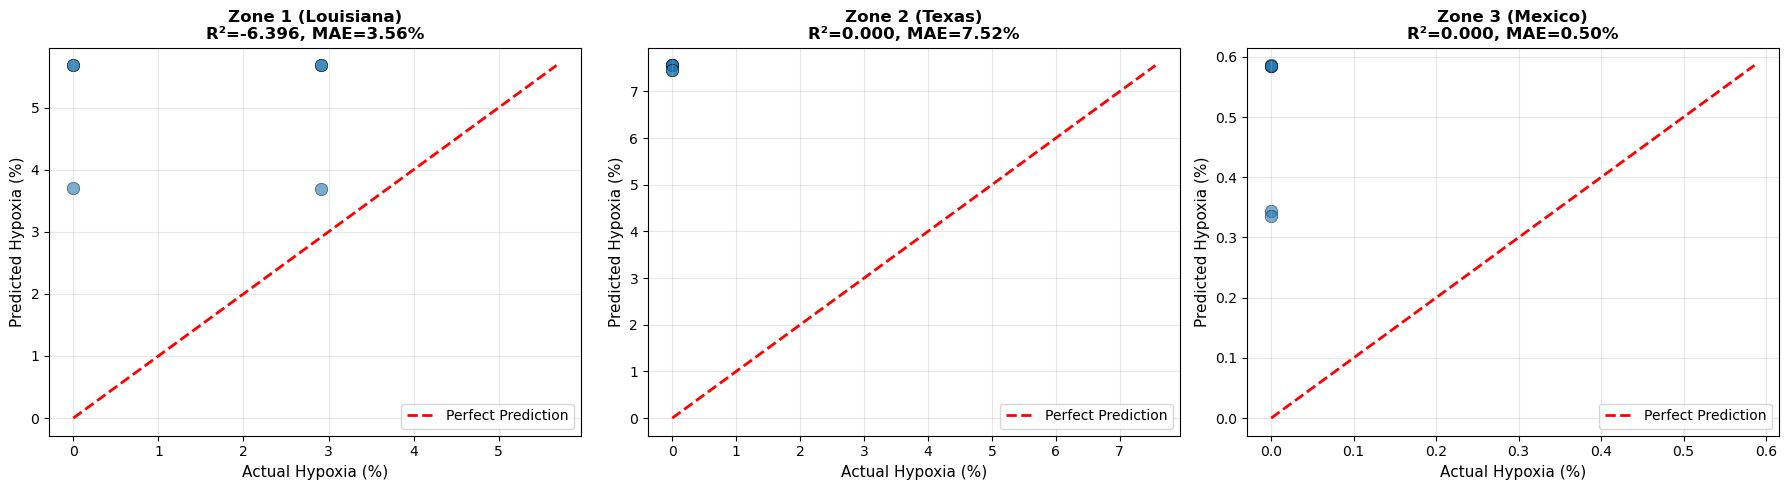

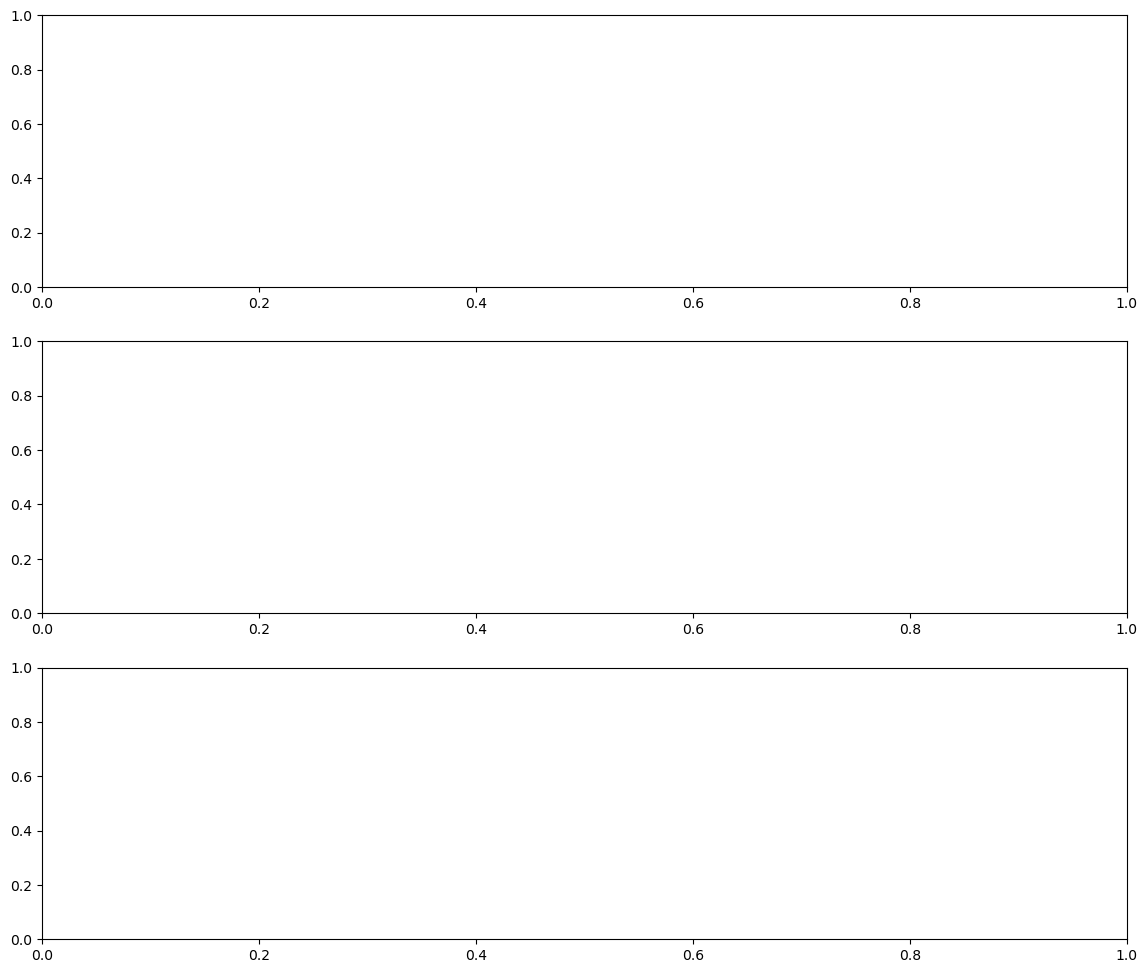

In [35]:

# Figure 1: Training histories
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (model_name, history) in enumerate(training_histories.items()):
    ax = axes[i]
    
    # Plot loss
    ax.plot(history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('MSE Loss', fontsize=10)
    ax.set_title(f'{model_name} - Training History', fontweight='bold', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(training_histories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_histories.png', dpi=150, bbox_inches='tight')
print("Saved: training_histories.png")

# Figure 2: Predictions vs Actual (Test Set) - Best Model
best_model = models_to_train[best_model_name]
best_results = results[best_model_name]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, zone_name in enumerate(zone_names):
    ax = axes[i]
    
    y_true = y_test[:, i]
    y_pred = best_results['test']['predictions'][:, i]
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    ax.set_xlabel('Actual Hypoxia (%)', fontsize=11)
    ax.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
    ax.set_title(f'{zone_name}\nR²={r2:.3f}, MAE={mae:.2f}%', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions_vs_actual_test.png', dpi=150, bbox_inches='tight')
print("Saved: predictions_vs_actual_test.png")

# Figure 3: Predictions over time (Test Set)
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

test_years = metadata['test_years']
test_horizons = metadata['test_horizons']

for i, zone_name in enumerate(zone_names):
    ax = axes[i]
    
    y_true = y_test[:, i]
    y_pred = best_results['test']['predictions'][:, i]
    
    x = np.arange(len(y_true))
    
    # Plot actual and predicted
    ax.plot(x, y_true, 'o-', label='Actual', linewidth=2, markersize=8)
    ax.plot(x, y_pred, 's--', label='Predicted', linewidth=2, markersize=8)
    
    # Add year labels
    ax.set_xticks(x)
    labels = [f"{year}\n{horizon.replace('_', ' ')}" for year, horizon in zip(test_years, test_horizons)]
    ax.set_xticklabels(labels, fontsize=9, rotation=0)
    
    ax.set_ylabel('Hypoxia (%)', fontsize=11)
    ax.set_title(f'{zone_name} - Test Set Predictions', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions_timeline_test.png', dpi=150, bbox_inches='tight')
print("Saved: predictions_timeline_test.png")